In [190]:
import os
if os.getcwd().endswith('/notebook'):
    os.chdir('..')

In [191]:
import pandas as pd
df = pd.read_csv('output/ontonote-svo.txt', sep='\t', names=['sbj', 'verb', 'dobj'])

In [192]:
df.sample(5)

,sbj,verb,dobj
9764,action,reflect,weakness
210,people,make,detour
10072,people,chase,promise
14306,network,press,fight
1890,battle,include,picture


In [193]:
len(df)

20885

In [194]:
from sklearn.model_selection import train_test_split

Randomly split the available tuples into training and testing. Following Cruys (2014), we will perform instance-based training and type-based testing. The duplicates in the training set gives the model a sense of typicality.

In [195]:
train_ds_pos, test_ds_pos = train_test_split(df, test_size=0.5, random_state=285230)
test_ds_pos = test_ds_pos.drop_duplicates()

Training set will only contain positive examples (because we're going to sample negative example during training) while test set will also contain negative examples chosen in the same frequency band.

In [196]:
import math

def compute_frequency_band_mapping(series):
    counts = series.value_counts()
    n_tenth = int(math.ceil(len(counts)/10))
    bands = [counts.iloc[i*n_tenth:(i+1)*n_tenth].index.values for i in range(10)]
    assert len(counts) == sum(len(band) for band in bands)
    return {val:band for band in bands for val in band}

In [197]:
dobj2band = compute_frequency_band_mapping(df['dobj'])

In [198]:
sbj2band = compute_frequency_band_mapping(df['sbj'])

In [199]:
import random
from collections import OrderedDict

In [200]:
pos_examples_as_set = set(tuple(row) for row in df.values)

In [201]:
rng = random.Random(238293)
test_examples = []
for _, pos_row in test_ds_pos.iterrows():
    pos_sbj, verb, pos_dobj = pos_row.values
    neg_sbj, neg_dobj = pos_sbj, pos_dobj
    while (neg_sbj, verb, neg_dobj) in pos_examples_as_set:
        neg_sbj = rng.choice(sbj2band[pos_sbj])
        neg_dobj = rng.choice(dobj2band[pos_dobj])
    test_examples.append(OrderedDict([('verb', verb), 
                                      ('pos_sbj', pos_sbj), ('pos_dobj', pos_dobj),
                                      ('neg_sbj', neg_sbj), ('neg_dobj', neg_dobj)]))
test_ds = pd.DataFrame(test_examples)

In [202]:
train_ds_pos.to_csv('output/ontonote-svo-train.txt', sep='\t', index=False, header=False)
test_ds.to_csv('output/ontonote-svo-test.txt', sep='\t', index=False, header=False)

# Examine the datasets

In [203]:
len(train_ds_pos)

10442

In [204]:
len(test_ds)

10056

In [205]:
%matplotlib inline
import seaborn as sns

In [206]:
train_pos_examine = train_ds_pos.copy()
train_pos_examine['type'] = 'train_pos'
test_pos_examine = (test_ds[['pos_sbj', 'verb', 'pos_dobj']].copy()
                    .rename(columns={'pos_sbj': 'sbj', 'pos_dobj': 'dobj'}))
test_pos_examine['type'] = 'test_pos'
test_neg_examine = (test_ds[['neg_sbj', 'verb', 'neg_dobj']].copy()
                    .rename(columns={'neg_sbj': 'sbj', 'neg_dobj': 'dobj'}))
test_neg_examine['type'] = 'test_neg'
ds_examine = pd.concat([train_pos_examine, test_pos_examine, test_neg_examine])

In [207]:
def plot_most_common_words(col_name, *args, **kwargs): 
    df = kwargs['data']
    df[col_name].value_counts().head(30).plot('bar', fontsize='small')
import matplotlib.pyplot as plt

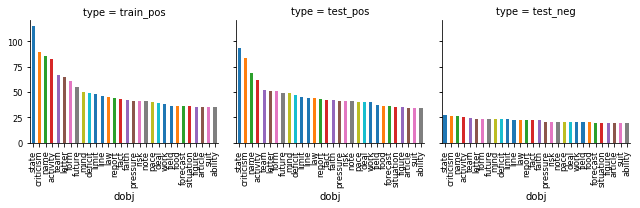

In [208]:
g = sns.FacetGrid(ds_examine, col='type')
_ = g.map_dataframe(plot_most_common_words, 'dobj')

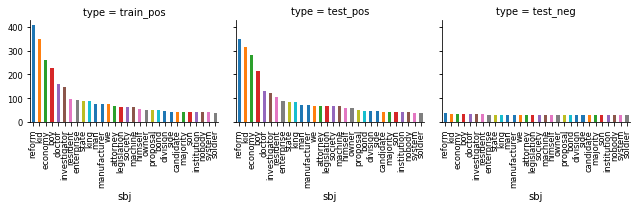

In [209]:
g = sns.FacetGrid(ds_examine, col='type')
_ = g.map_dataframe(plot_most_common_words, 'sbj')

In [210]:
test_ds.sample(10)

,verb,pos_sbj,pos_dobj,neg_sbj,neg_dobj
8421,reach,hysteria,pitch,rerun,suicide
4480,put,representative,plan,i,dividend
1127,have,outlook,tilt,recommendation,u-turn
8696,take,individual,time,operation,plant
2135,give,public,attention,worker,number
3078,foot,company,amount,statement,package
334,count,state,vote,president,voice
3583,adopt,market,breaker,computer,church
1135,get,hundred,nothing,account,bill
9034,have,family,son,firm,judge


# Encode into numerical values

In [211]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [212]:
encoder.fit(list(train_ds_pos.values.reshape(-1)) + ['<unkn>'])
vocab = set(encoder.classes_)

In [213]:
len(vocab)

4466

In [214]:
def transform_dataset(df):
    num_cols = len(df.columns)
    vals = df.values.reshape(-1)
    vals = [(v if v in vocab else '<unkn>') for v in vals]
    x = encoder.transform(vals).reshape(-1, num_cols)
    return x

In [215]:
encoded_train_ds_pos = transform_dataset(train_ds_pos[['verb', 'sbj', 'dobj']])
encoded_test_ds = transform_dataset(test_ds[['verb', 'pos_sbj', 'pos_dobj', 'neg_sbj', 'neg_dobj']])

In [216]:
encoded_train_ds_pos[:5]

array([[1738, 2807, 4358],
       [3921, 2572, 1321],
       [1386, 1855, 3894],
       [1849,  793, 2867],
       [3468, 1764, 1434]])

In [217]:
encoded_test_ds[:5]

array([[2338, 1494,  474, 1928, 3341],
       [1849, 2544, 3853, 2909, 2210],
       [2338, 2603, 3306, 4057, 3397],
       [   7, 3236,  651,  408, 4323],
       [3530, 1693, 2112,  836, 3367]])

In [218]:
from joblib import dump

In [219]:
dump(encoder, 'output/ontonote-encoder.pkl')

['output/ontonote-encoder.pkl']

In [220]:
import numpy as np
np.save('output/ontonote-svo-train.npy', encoded_train_ds_pos)
np.save('output/ontonote-svo-test.npy', encoded_test_ds)

# Coverage

In [221]:
sum(1 for w in test_ds.values.flatten() if w in vocab)

47528

In [222]:
test_ds.values.size

50280